In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from torchvision import datasets, transforms
from model import Net, ConvNet
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 64

import matplotlib.pyplot as plt

In [2]:
# hard-code random seeds for deterministic outcomes
np.random.seed(42)
torch.manual_seed(42)

In [3]:
# loading the dataset
# note that this time we do not perfrom the normalization operation, see next cell
test_dataset = datasets.MNIST(
    'mnist_data/', 
    train=False, 
    download=True, 
    transform=transforms.Compose(
        [transforms.ToTensor()]
    )
)

In [4]:
class Normalize(nn.Module):
    def forward(self, x):
        return (x - 0.1307)/0.3081

# we load the body of the pre-trained neural net...
model = torch.load('model.net', map_location='cpu') 

# ... and add the data normalization as a first "layer" to the network
# this allows us to search for adverserial examples to the real image, rather than
# to the normalized image
model = nn.Sequential(Normalize(), model)

# and here we also create a version of the model that outputs the class probabilities
model_to_prob = nn.Sequential(model, nn.Softmax())

# we put the neural net into evaluation mode (this disables features like dropout)
model.eval()
model_to_prob.eval()

/Users/gaiadilorenzo/.pyenv/versions/3.10.6/lib/python3.10/site-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/gaiadilorenzo/.pyenv/versions/3.10.6/lib/python3.10/site-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/gaiadilorenzo/.pyenv/versions/3.10.6/lib/python3.10/site-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout2d' 

Sequential(
  (0): Sequential(
    (0): Normalize()
    (1): ConvNet(
      (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2_drop): Dropout2d(p=0.2, inplace=False)
      (fc1): Linear(in_features=128, out_features=100, bias=True)
      (fc2): Linear(in_features=100, out_features=10, bias=True)
      (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (bn5): BatchNorm2d(128, eps=1e-05, momentum=

In [5]:
def show(original, adv, model_to_prob):
    p0 = model_to_prob(original).detach().numpy()
    p1 = model_to_prob(adv).detach().numpy()
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(original.detach().numpy().reshape(28, 28), cmap='gray')
    axarr[0].set_title("Original, class: " + str(p0.argmax()))
    axarr[1].imshow(adv.detach().numpy().reshape(28, 28), cmap='gray')
    axarr[1].set_title("Adversarial, class: " + str(p1.argmax()))
    print("Class\t\tOrig\tAdv")
    for i in range(10):
        print("Class {}:\t{:.2f}\t{:.2f}".format(i, float(p0[:, i]), float(p1[:, i])))
    plt.show()

In [6]:
# x: input image
# label: current label of x
# eps: size of l-infinity ball
def fgsm_untargeted(model, x, label, eps, **kwargs):
    adv_x = x.clone().detach()
    with torch.enable_grad():
        adv_x.requires_grad = True
        output = model_to_prob(adv_x)
        loss = nn.functional.cross_entropy(output, target=torch.tensor(label).unsqueeze(dim=0))
        loss.backward()
    x_prime = x + eps * torch.sign(adv_x.grad)
    return torch.clip(x_prime, min=kwargs["clip_min"], max=kwargs["clip_max"])


In [9]:
# x: input image
# label: current label of x
# k: number of FGSM iterations
# eps: size of l-infinity ball
# eps_step: step size of FGSM iterations
def pgd(model, x, label, k, eps, eps_step, targeted, clip_min, clip_max):
    # TODO: 
    x_adv = x.clone().detach()
    for i in range(k):
        x_adv = fgsm_untargeted(model, x_adv, label, eps, clip_min=clip_min, clip_max=clip_max)
    return x_adv


/Users/gaiadilorenzo/.pyenv/versions/3.10.6/lib/python3.10/site-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([[[[0.3000, 0.1500, 0.1500, 0.4500, 0.6000, 0.6000, 0.6000, 0.0000,
           0.6000, 0.3000, 0.8500, 0.3000, 0.0000, 0.9000, 0.0000, 1.0000,
           0.3000, 0.1500, 0.1500, 0.3000, 0.0000, 0.0000, 0.3000, 0.3000,
           0.3000, 1.0000, 0.7500, 0.0000],
          [0.0000, 0.3000, 0.6000, 0.9000, 0.4500, 0.6000, 0.3000, 0.3000,
           0.3000, 0.6000, 0.9000, 0.0000, 0.3000, 0.1500, 0.7500, 1.0000,
           0.6000, 0.0000, 0.3000, 0.1500, 0.1500, 0.0000, 0.0000, 0.3000,
           0.1500, 0.6000, 0.6000, 0.1500],
          [0.3000, 0.3000, 0.1500, 0.0000, 0.3000, 0.3000, 0.1500, 0.7500,
           0.9000, 0.7500, 0.6000, 0.3000, 0.3000, 0.4500, 0.3000, 0.3000,
           0.3000, 0.0000, 0.7500, 0.1500, 0.0000, 0.0000, 0.0000, 0.1500,
           0.7500, 0.3000, 0.7500, 0.1500],
          [0.0000, 0.4500, 0.7500, 0.0000, 0.0000, 0.3000, 0.0000, 0.0000,
           0.6000, 0.4500, 0.6000, 0.7500, 0.1500, 0.3000, 0.7500, 0.7500,
           0.0000, 0.0000, 0.1500, 0.0000, 

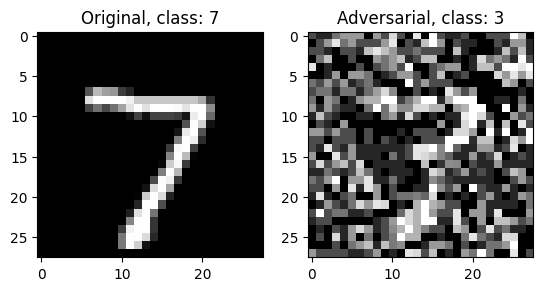

In [10]:
# try out our attacks
original = torch.unsqueeze(test_dataset[0][0], dim=0)

adv = pgd(model, original, label=7, k=10, eps=0.15, eps_step=0.05, targeted=False, clip_min=0, clip_max=1.0)

show(original, adv, model_to_prob)